# Anyone AI

# Project III - Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all together. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. The competition finished 4 years ago, so you will find a lot of blog posts and code written for it, we encourage you to read everything you can about it.

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

1- Login to Kaggle (if you don't have an account you'll have to register to get it) and download the [complete dataset](https://www.kaggle.com/competitions/home-credit-default-risk/data). Read the information about the data. What does a row in the main file represent? What does the target variable means?

In [111]:
!pip install -q kaggle
!pip install plotly
import json
# from google.colab import files

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly import tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from scipy.stats import iqr
from datetime import datetime as dt
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import re
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = None

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [147]:
k = {"username":"nicolasmengochea",
     "key":"c93cfa7017ca4c7082e7bb521ec99ecc"}
with open('kaggle.json', 'w') as fp:
  json.dump(k, fp)
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c home-credit-default-risk
!mkdir home-credit-default-risk
!unzip home-credit-default-risk.zip -d home-credit-default-risk

La sintaxis del comando no es correcta.
"cp" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"chmod" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.



  0%|          | 0.00/688M [00:00<?, ?B/s]
  0%|          | 1.00M/688M [00:00<02:16, 5.27MB/s]
  0%|          | 2.00M/688M [00:00<01:53, 6.36MB/s]
  0%|          | 3.00M/688M [00:00<01:53, 6.34MB/s]
  1%|          | 4.00M/688M [00:00<01:50, 6.50MB/s]
  1%|          | 5.00M/688M [00:00<01:44, 6.83MB/s]
  1%|          | 6.00M/688M [00:00<01:48, 6.61MB/s]
  1%|1         | 7.00M/688M [00:01<01:43, 6.89MB/s]
  1%|1         | 8.00M/688M [00:01<01:46, 6.67MB/s]
  1%|1         | 9.00M/688M [00:01<01:43, 6.90MB/s]
  1%|1         | 10.0M/688M [00:01<01:43, 6.89MB/s]
  2%|1         | 11.0M/688M [00:01<01:43, 6.87MB/s]
  2%|1         | 12.0M/688M [00:01<01:40, 7.03MB/s]
  2%|1         | 13.0M/688M [00:02<01:41, 6.97MB/s]
  2%|2         | 14.0M/688M [00:02<01:42, 6.92MB/s]
  2%|2         | 15.0M/688M [00:02<01:42, 6.91MB/s]
  2%|2         | 16.0M/688M [00:02<01:39, 7.06MB/s]
  2%|2         | 17.0M/688M [00:02<01:40, 7.00MB/s]
  3%|2         | 18.0M/688M [00:02<01:38, 7.13MB/s]
  3%|2         | 19.

### Exploratory Data Analysis

A lot of the analysis of the data can be found on public available Kaggle kernels or blog posts, but you need to make sure you understand the datasets properties before starting working on it, so we'll do exploratory data analysis for the main files

**Dataset Basics**

1- Show the shape of the training and test datasets.

In [167]:
application_test = pd.read_csv('DataSets/application_test.csv')
application_train = pd.read_csv('DataSets/application_train.csv')
application_test.insert(1, 'TARGET', np.zeros(len(application_test)))

In [115]:
print(application_train.info())
print('--------------------------')
print(application_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
--------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(40), object(16)
memory usage: 45.4+ MB
None


2- List all columns in the train dataset

In [116]:
for column in application_train:
    if column not in application_test.columns:
        print(f"Missing column: ", column)
print('--------------------------------------------------------------------------------------')
print(list(application_train.columns))

--------------------------------------------------------------------------------------
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASE

3- Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

In [117]:
a = application_train.head(5)
a = a.T
a

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5


4- Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

0    282686
1     24825
Name: TARGET, dtype: int64


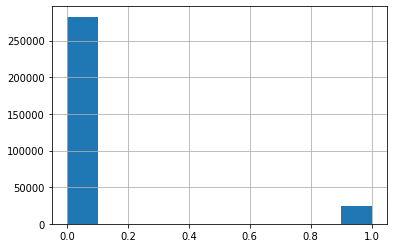

In [118]:
application_train['TARGET'].hist()
print(application_train['TARGET'].value_counts())

([<matplotlib.patches.Wedge at 0x16f403cc850>,
 [Text(-1.0648123216659293, 0.27599768047650985, 'Negative'),
  Text(1.0648123152057372, -0.27599770540024077, 'Positive')],
 [Text(-0.5808067209086887, 0.15054418935082356, '92%'),
  Text(0.5808067173849475, -0.15054420294558588, '8%')])

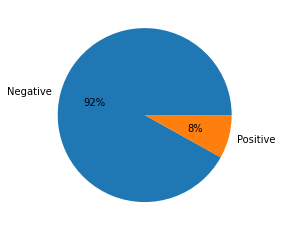

In [119]:
plt.pie(application_train['TARGET'].value_counts(), labels=['Negative','Positive'], autopct='%.0f%%')

5- Show the number of columns of each data type

In [120]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

6- For categorical variables, show the number of distinct values in each column (number of labels)

In [165]:
def get_categoricals(train, criteria='Int and narrowed objects'):
    """
    The criteria for categoricals selection will impact in feature encoding.
    """
    df_categoricals = pd.DataFrame()
    df_categoricals['column_name'] = train.columns
    df_categoricals['dtype'] = np.array(train.dtypes)
    df_categoricals['n_uniques'] = np.array(train.nunique())
    # -----------------------------------------------------------------------------------
    # Filters
    type_object = df_categoricals['dtype'] == 'object'
    type_int = df_categoricals['dtype'] == ('int64')
    nunique_lt_2 = df_categoricals['n_uniques'] <= 2
    # -----------------------------------------------------------------------------------
    # Object nunique bounds
    objects_nuniques = df_categoricals[type_object]['n_uniques']
    upper_bound_nuniques = (np.quantile(objects_nuniques, 0.75) - np.quantile(objects_nuniques, 0.25)) * 1.5 \
                           + (np.quantile(objects_nuniques, 0.75))
    not_outlier_nuniques = df_categoricals['n_uniques'] < upper_bound_nuniques
    # -----------------------------------------------------------------------------------
    # Criteria options
    if criteria == 'Int and narrowed objects':
        df_categoricals = df_categoricals[
            (type_int & nunique_lt_2) |
            (type_object & not_outlier_nuniques)]
    elif criteria == 'Objects':
        df_categoricals = df_categoricals[type_object]
    elif criteria == 'Only narrow objects':
        df_categoricals = df_categoricals[(type_object & not_outlier_nuniques)]

    df_categoricals.set_index('column_name', inplace=True)
    return df_categoricals

In [168]:
categoricals = get_categoricals(application_train, criteria='Objects')
categoricals

,dtype,n_uniques
column_name,,
NAME_CONTRACT_TYPE,object,2
CODE_GENDER,object,3
FLAG_OWN_CAR,object,2
FLAG_OWN_REALTY,object,2
NAME_TYPE_SUITE,object,7
NAME_INCOME_TYPE,object,8
NAME_EDUCATION_TYPE,object,5
NAME_FAMILY_STATUS,object,6
NAME_HOUSING_TYPE,object,6


7- Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [123]:
missing_values = pd.DataFrame(application_train.isna().sum() / application_train.count().max(), columns=['data'])
missing_values.sort_values('data', ascending=False, inplace=True)
missing_values.head(20)

,data
COMMONAREA_MEDI,0.698723
COMMONAREA_AVG,0.698723
COMMONAREA_MODE,0.698723
NONLIVINGAPARTMENTS_MODE,0.694330
NONLIVINGAPARTMENTS_AVG,0.694330
NONLIVINGAPARTMENTS_MEDI,0.694330
FONDKAPREMONT_MODE,0.683862
LIVINGAPARTMENTS_MODE,0.683550
LIVINGAPARTMENTS_AVG,0.683550
LIVINGAPARTMENTS_MEDI,0.683550


**Analyzing distribution of variables**

1- Show the distribution of credit amounts

<AxesSubplot:>

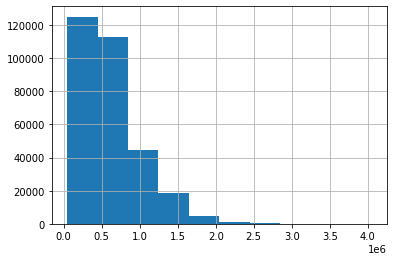

In [124]:
application_train['AMT_CREDIT'].hist()

2- Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64


([<matplotlib.patches.Wedge at 0x16f5ed0ed40>,
 [Text(-0.6747143291350378, 0.8687695747779476, 'Secondary'),
  Text(0.5414786909946752, -0.957497168245783, 'Higher education'),
  Text(1.0809633059124244, -0.20376047524209107, 'Incomplete higher'),
  Text(1.099014363537664, -0.04655565205110499, 'Lower secondary'),
  Text(1.0999984559777936, -0.0018430535722772324, 'Academic degree')],
 [Text(-0.3680259977100206, 0.47387431351524406, '71%'),
  Text(0.29535201326982274, -0.5222711826795179, '24%'),
  Text(0.5896163486795041, -0.11114207740477693, '3%'),
  Text(0.599462380111453, -0.025393992027875446, '1%'),
  Text(0.5999991578060692, -0.001005301948514854, '0%')])

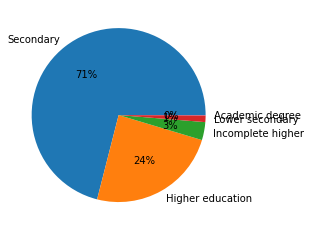

In [125]:
print(application_train['NAME_EDUCATION_TYPE'].value_counts())
plt.pie(application_train['NAME_EDUCATION_TYPE'].value_counts(), labels=['Secondary','Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree'], autopct='%.0f%%')

3- Plot the distribution of ocupation of the loan applicants

<AxesSubplot:>

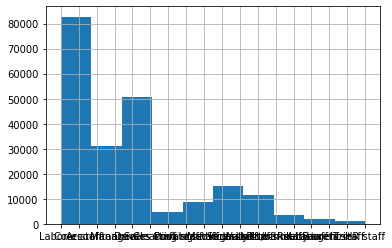

In [164]:
application_train['OCCUPATION_TYPE'].hist()

In [127]:
def gp(col, title):
    df1 = application_train[application_train["TARGET"] == 1]
    df0 = application_train[application_train["TARGET"] == 0]
    a1 = df1[col].value_counts()
    b1 = df0[col].value_counts()

    total = dict(application_train[col].value_counts())
    x0 = a1.index
    x1 = b1.index

    y0 = [float(x)*100 / total[x0[i]] for i,x in enumerate(a1.values)]
    y1 = [float(x)*100 / total[x1[i]] for i,x in enumerate(b1.values)]

    trace1 = go.Bar(x=a1.index, y=y0, name='Target : 1', marker=dict(color="#96D38C"))
    trace2 = go.Bar(x=b1.index, y=y1, name='Target : 0', marker=dict(color="#FEBFB3"))
    return trace1, trace2

In [128]:
def bar_hor(df, col, title, color, w=None, h=None, lm=0, limit=100, return_trace=False, rev=False, xlb = False):
    cnt_srs = df[col].value_counts()
    yy = cnt_srs.head(limit).index[::-1]
    xx = cnt_srs.head(limit).values[::-1]
    if rev:
        yy = cnt_srs.tail(limit).index[::-1]
        xx = cnt_srs.tail(limit).values[::-1]
    if xlb:
        trace = go.Bar(y=xlb, x=xx, orientation = 'h', marker=dict(color=color))
    else:
        trace = go.Bar(y=yy, x=xx, orientation = 'h', marker=dict(color=color))
    if return_trace:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

4- Plot the family status of the applicants

In [129]:
tr0 = bar_hor(application_train, "NAME_FAMILY_STATUS", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('NAME_FAMILY_STATUS', 'Distribution of Target with Applicant Gender')

fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Family Status Distribution" , "Family Status, Target = 1" ,"Family Status, Target = 0"])
fig.append_trace(tr0, 1, 1)
fig.append_trace(tr1, 1, 2)
fig.append_trace(tr2, 1, 3)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)

5- Plot the income type of applicants grouped by the target variable

In [130]:
tr1, tr2 = gp('NAME_INCOME_TYPE', 'Applicants Income Types which repayed the loan')
fig = tools.make_subplots(rows=1, cols=2, print_grid=False,
                          subplot_titles = ["Applicants Income Types when Target = 1", "Applicants Income Type When Target = 0"])
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120))
iplot(fig)

## Preprocessing

In this section, you will code a function to make all the data pre processing for the dataset. What you have to deliver is a function that takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities:

- Correct outliers/anomalous values in numerical columns (hint: take a look at the DAYS_EMPLOYED column)
- Impute values for all columns with missing data (use median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

Keep in mind that you could get different number of columns in train and test because some category could only be present in one of the dataframes, this could create more one hot encoded columns. You should align train and test to have the same number of columns

In [131]:
def equalize_train_test(train, test):
    train['NAME_INCOME_TYPE'] = train['NAME_INCOME_TYPE'].replace(['Maternity leave'], 'Working')
    # train['CODE_GENDER'] = train['CODE_GENDER'].replace(['XNA'], 'F')
    train = train.replace(['XNA', 'XAP'], np.nan)
    test = test.replace(['XNA', 'XAP'], np.nan)
    train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace = True)
    train['NAME_FAMILY_STATUS'] = train['NAME_FAMILY_STATUS'].replace(['Unknown'], 'Married')
    return train,test

In [132]:
def get_numerical_bounds(train, categoricals, index, bound_mult=1.5):
    df_numerical = pd.DataFrame()
    df_numerical['column_name'] = train.columns
    df_numerical['dtype'] = np.array(train.dtypes)
    df_numerical = df_numerical[df_numerical['dtype'] != 'object']
    df_numerical.reset_index(inplace=True, drop=True)

    for i in range(len(df_numerical)):
        df_numerical.loc[i, 'upper bound'] = np.quantile(train[df_numerical.loc[i, 'column_name']], 0.75) + iqr(
            train[df_numerical.loc[i, 'column_name']]) * bound_mult
        df_numerical.loc[i, 'lower bound'] = np.quantile(train[df_numerical.loc[i, 'column_name']], 0.25) - iqr(
            train[df_numerical.loc[i, 'column_name']]) * bound_mult
        df_numerical = df_numerical.fillna(0)

    df_numerical = pd.merge(df_numerical, categoricals, on=['column_name'], how="outer", indicator=True).query(
        '_merge=="left_only"')
    df_numerical = df_numerical[df_numerical['upper bound'] > 10]
    df_numerical.drop(['dtype_y', 'n_uniques', '_merge'], axis=1, inplace=True)
    df_numerical.set_index('column_name', inplace=True)
    df_numerical.drop([index, 'HOUR_APPR_PROCESS_START'], axis=0, inplace=True)
    return df_numerical

In [133]:
def manage_outliers(df_numerical, train, outl_treatment='Filter'):
    print(f"Original DF Lenght: {len(train)}")
    for column in train:
        if outl_treatment == 'Filter':
            if column in list(df_numerical.index):
                train = train[train[column] < df_numerical.loc[column, 'upper bound']]
                train = train[train[column] > df_numerical.loc[column, 'lower bound']]
        elif outl_treatment == 'Mean':
            if column in list(df_numerical.index):
                values_inside_range = train[column][(train[column] < df_numerical.loc[column, 'upper bound']) &
                                            (train[column] > df_numerical.loc[column, 'lower bound'])]
                mean_vir = float(values_inside_range.mean())
                train[column][(train[column] > df_numerical.loc[column, 'upper bound']) &
                                       (train[column] < df_numerical.loc[column, 'lower bound'])] = mean_vir
        else:
            break
    print(f"Post processing DF Lenght: {len(train)}")
    return train

In [134]:
def imputing_values(train, test, categoricals, object_treatment='Mode'):
    imp = SimpleImputer(missing_values=np.nan, strategy='median')

    for column in train:
        if train[column].dtypes != 'object':
            train[column] = imp.fit_transform(train[column].values.reshape(-1, 1))
            test[column] = imp.transform(test[column].values.reshape(-1, 1))

    if object_treatment == 'Drop rows if nans':
        for column in train:
            if train[column].dtypes == 'object':
                train = train.dropna(axis=0, how='any', subset=column)
        return train, test, categoricals
    elif object_treatment == 'Drop columns if nans':
        for column in train:
            if train[column].dtypes == 'object' and train[column].isna().any():
                train = train.drop(column, axis=1)
                categoricals = categoricals[categoricals.index != column]
            if test[column].dtypes == 'object' and test[column].isna().any():
                test = test.drop(column, axis=1)
        train, test = train.align(test, join='inner', axis=1)
        return train, test, categoricals
    elif object_treatment == 'Mode':
        imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for column in train:
            if train[column].dtypes == 'object':
                train[column] = imp2.fit_transform(train[column].values.reshape(-1, 1))
                test[column] = imp2.transform(test[column].values.reshape(-1, 1))
        return train, test, categoricals
    else:
        raise ValueError('Wrong parameter')

In [135]:
def feature_encoding(train, test, categoricals):
    lb = LabelBinarizer()
    oh = OneHotEncoder(handle_unknown='ignore')
    trindex = train.index
    teindex = test.index
    for column_name in list(categoricals.index):
        try:
            if categoricals.loc[column_name, 'n_uniques'] <= 2:
                train[column_name] = lb.fit_transform(train[column_name])
                test[column_name] = lb.transform(test[column_name])
            elif categoricals.loc[column_name, 'n_uniques'] > 2:
                # Train Set --------------------------------------------------------------------------------------------
                train_encoded = pd.DataFrame(oh.fit_transform(train[[column_name]]).toarray(), index=trindex)
                train_encoded.columns = oh.get_feature_names_out([column_name])
                train_encoded.columns = train_encoded.columns.str.replace(column_name + '_', '')
                # Test Set ---------------------------------------------------------------------------------------------
                test_encoded = pd.DataFrame(oh.transform(test[[column_name]]).toarray(), index=teindex)
                test_encoded.columns = oh.get_feature_names_out([column_name])
                test_encoded.columns = test_encoded.columns.str.replace(column_name + '_', '')
                train, test = train.drop(column_name, axis=1), test.drop(column_name, axis=1)
                train, test = pd.concat([train, train_encoded], axis=1), pd.concat([test, test_encoded], axis=1)
            else:
                pass
        except:
            pass
    return train, test

In [136]:
# Function to Scale only numerical features from a given dataset, using a given Scaling method.
def numerical_scaler(train, test, scaling_method):
    columns_drop_list = []
    trindex = train.index
    teindex = test.index
    for column in train:
        print(column)
        if train[column].dtypes in ['float', 'float64', 'int64']:
            pass
        else:
            columns_drop_list.append(column)

    columns_drop_list.append('TARGET') # IF MINMAXSCALER, COMMENT. #####################################################
    train_numeric = train.drop(columns_drop_list, axis=1)
    test_numeric = test.drop(columns_drop_list, axis=1)
    train_numeric_columns = train_numeric.columns
    test_numeric_columns = test_numeric.columns
    scaler = scaling_method
    train_numeric = pd.DataFrame(scaler.fit_transform(train_numeric), columns=train_numeric_columns, index=trindex)
    test_numeric = pd.DataFrame(scaler.transform(test_numeric), columns=test_numeric_columns, index=teindex)
    train, test = (pd.concat([train[columns_drop_list], train_numeric], axis=1),
                   pd.concat([test[columns_drop_list], test_numeric], axis=1))
    return train, test

In [137]:
# Manual align between Dfs.
def train_test_column_dif(train:pd.DataFrame, test:pd.DataFrame):
    columns_train = list(train.columns)
    columns_test = list(test.columns)

    for column in columns_train:
        if column not in columns_test:
            test[column] = np.zeros(len(test))

    for column in columns_test:
        if column not in columns_train:
            train[column] = np.zeros(len(train))
    return train, test

In [138]:
def preprocessing(train: pd.DataFrame, test, index: str):
    train, test = equalize_train_test(train, test)
    categoricals = get_categoricals(train, criteria='Objects')                                                          # 'Int and narrowed objects' / 'Objects' / 'Only narrow objects'
    df_numerical = get_numerical_bounds(train, categoricals, index, bound_mult=1)                                       # Any
    train = manage_outliers(df_numerical, train, outl_treatment='Filter')                                               # None(only 365243) / Filter / Mean
    train, test, categoricals = imputing_values(train, test, categoricals, object_treatment='Mode')                     # Drop rows if nans / Drop columns if nans / Mode
    train, test = feature_encoding(train, test, categoricals)
    # ============================================
    train[index], test[index] = train[index].astype('int64'), test[index].astype('int64')
    train.set_index(index, inplace=True)
    test.set_index(index, inplace=True)
    # ============================================
    train, test = numerical_scaler(train, test, StandardScaler())                                                       # MinMaxScaler() / StandardScaler()
    train, test = train.select_dtypes(exclude=['object']), test.select_dtypes(exclude=['object'])
    train, test = train_test_column_dif(train, test)
    return train, test

In [139]:
application_train, application_test = preprocessing(application_train, application_test, 'SK_ID_CURR')

Original DF Lenght: 307511
Post processing DF Lenght: 264248
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_

In [140]:
X_train = application_train.drop('TARGET', axis=1)
y_train = application_train['TARGET'].copy()
ytrainhead = y_train.head()
X_test = application_test.drop('TARGET', axis=1)

## Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

1- Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter 

In [141]:
"""
**N° 1 Try:

Categoricals (encoding related): Int and narrowed objects
Bounds: 1.5
Outlier treatment: None
Nan object treatment: Mode
Scaler: MinMaxScaler

**Result: 0.73113
=====================================================================================
=====================================================================================
**N° 2 Try:

Categoricals (encoding related): Objects
Bounds: 1.5
Outlier treatment: None
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73385
=====================================================================================
=====================================================================================
**N° 3 Try:

Categoricals (encoding related): Objects
Bounds: 1.5
Outlier treatment: None
Nan object treatment: Mode
Scaler: MinMaxScaler

**Result: 0.73038
=====================================================================================
=====================================================================================
**N° 4 Try:

Categoricals (encoding related): Only narrow objects
Bounds: 1.5
Outlier treatment: None
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73197
=====================================================================================
=====================================================================================
**N° 5 Try:

Categoricals (encoding related): Objects
Bounds: 1.5
Outlier treatment: Filter
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73434
=====================================================================================
=====================================================================================
**N° 6 Try:

Categoricals (encoding related): Objects
Bounds: 2
Outlier treatment: Filter
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73426
=====================================================================================
=====================================================================================
**N° 7 Try:

Categoricals (encoding related): Objects
Bounds: 1
Outlier treatment: Filter
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73472
=====================================================================================
=====================================================================================
**N° 8 Try:
**Even though with 0.5 bounds the result is slightly better I think there's way more risk of overfitting, and it is not worth it.**

Categoricals (encoding related): Objects
Bounds: 0.5
Outlier treatment: Filter
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73478
=====================================================================================
=====================================================================================
**N° 9 Try:
Categoricals (encoding related): Objects
Bounds: 1
Outlier treatment: Mean
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73385
=====================================================================================
=====================================================================================
**N° 10 Try:
Categoricals (encoding related): Objects
Bounds: 1
Outlier treatment: Filter
Nan object treatment: Drop rows if nans
Scaler: StandardScaler

**Result: 0.61486
=====================================================================================
=====================================================================================
**N° 12 Try:
Categoricals (encoding related): Objects
Bounds: 2.5
Outlier treatment: Mean
Nan object treatment: Drop rows if nans
Scaler: StandardScaler

**Result: 0.61212
=====================================================================================
=====================================================================================
**N° 13 Try:
Categoricals (encoding related): Objects
Bounds: 1
Outlier treatment: Filter
Nan object treatment: Drop columns if nans
Scaler: StandardScaler

**Result: 0.72924
=====================================================================================
=====================================================================================
**N° 14 Try:
Categoricals (encoding related): Objects
Bounds: 2
Outlier treatment: Mean
Nan object treatment: Drop columns if nans
Scaler: StandardScaler

**Result: 0.72880
=====================================================================================
=====================================================================================
**N° 15 Try:
**Even though with 0.5 bounds the result is slightly better I think there's way more risk of overfitting, and it is not worth it.**
Categoricals (encoding related): Objects
Bounds: 1
Outlier treatment: Filter
Nan object treatment: Mode
Scaler: StandardScaler

**Result: 0.73472
"""

"\n**N° 15 Try:\n**Even though with 0.5 bounds the result is slightly better I think there's way more risk of overfitting, and it is not worth it.**\nCategoricals (encoding related): Objects\nBounds: 1\nOutlier treatment: Filter\nNan object treatment: Mode\nScaler: StandardScaler\n\n**Result: 0.73472\n"

In [142]:
# Logistic Regressor - Default
lr = LogisticRegression(C=0.1, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42)

2- Use the trained model to predict probabilites for the test data, and then save the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities. REMEMBER: the TARGET columns should ONLY contain the probabilities that the debt is not repaid (equivalent to the class 1).

In [143]:
predict_proba = lr.predict_proba(X_test)[:, 1]
predictions_df = pd.DataFrame({'SK_ID_CURR':X_test.index, 'TARGET':predict_proba})
predictions_df.to_csv('predictions_df.csv', index=False)

# Private Score: 0.73472

3- Go to the Kaggle competition, and in the [submissions page](https://www.kaggle.com/competitions/home-credit-default-risk/submit) load your csv file. Report here the result in the private score you obtained.

In [148]:
!kaggle competitions submit -c home-credit-default-risk -f predictions_df.csv -m "" -q
!kaggle competitions submissions -v home-credit-default-risk > submissions.csv

Successfully submitted to Home Credit Default Risk


In [155]:
submissions = pd.read_csv("submissions.csv")
print(submissions.loc[submissions.fileName =='predictions_df.csv'][['fileName','privateScore']])

              fileName  privateScore
0   predictions_df.csv       0.73472
4   predictions_df.csv       0.73472
5   predictions_df.csv       0.72880
6   predictions_df.csv       0.72924
7   predictions_df.csv       0.61212
8   predictions_df.csv       0.61486
9   predictions_df.csv       0.73385
10  predictions_df.csv       0.73385
11  predictions_df.csv       0.73385
12  predictions_df.csv       0.73468
13  predictions_df.csv       0.73478
14  predictions_df.csv       0.73472
15  predictions_df.csv       0.73426
16  predictions_df.csv       0.73434
17  predictions_df.csv       0.73197
18  predictions_df.csv       0.73038
19  predictions_df.csv       0.73385
20  predictions_df.csv       0.73113
21  predictions_df.csv       0.67325
22  predictions_df.csv       0.67325
23  predictions_df.csv       0.63049
24  predictions_df.csv       0.59970
25  predictions_df.csv       0.65850
26  predictions_df.csv       0.65145
27  predictions_df.csv       0.64362
28  predictions_df.csv       0.64389
2

At this point, the model should produce a result around 0.67 

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

1- Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [152]:
def search_best_hyperparameters(search_method, train, train_targets, model, param_grid, cv=3, n_iter=None, scoring=None):
    # param_grid = [{str(key): value for key, value in kwargs.items()}]
    search = search_method(model, param_grid, cv=cv, n_iter=n_iter, scoring=scoring, return_train_score=True)
    search.fit(train, train_targets.ravel())

    best_params = search.best_params_
    best_params.update({'random_state': 42})
    best_score = search.best_score_
    results = search.cv_results_

    return best_params, best_score, results

In [153]:
def tuned_model_evaluation(X_train, y_train, X_test, model, params:dict):
    tuned_model = model(**{key:value for key, value in params.items()})
    tuned_model.fit(X_train, y_train)
    tuned_proba = tuned_model.predict_proba(X_test)[:, 1]
    tuned_predictions = pd.DataFrame({'SK_ID_CURR':X_test.index, 'TARGET':tuned_proba})
    # tuned_predictions.to_csv('tuned_predictions_rfc.csv', index=False)
    tuned_predictions.to_csv('tuned_predictions_lr2.csv', index=False)

    return tuned_predictions

In [ ]:
# ======================================================================================================================
# Random Forest Classifier - Default
start = dt.now()
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
predict_proba_rfc = rfc.predict_proba(X_test)[:, 1]
predictions_rfc = pd.DataFrame({'SK_ID_CURR':X_test.index, 'TARGET':predict_proba_rfc})
predictions_rfc.to_csv('predictions_rfc.csv', index=False)

3- Load the predictions to the competition. Report the private score here.

In [154]:
# !kaggle competitions submissions -v home-credit-default-risk > submissions.csv
submissions = pd.read_csv("submissions.csv")
print(submissions.loc[submissions.fileName =='predictions_rfc.csv'][['fileName','privateScore']])

              fileName  privateScore
3  predictions_rfc.csv       0.68799


### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


1- Use RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models should be "roc_auc".

2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
# ======================================================================================================================
# Random Forest Classifier - Tuned
param_grid = {
 'bootstrap': [True, False],
 'max_depth': [10, 50, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200]
}

best_params, best_score, results  = search_best_hyperparameters(RandomizedSearchCV, X_train, y_train, rfc, param_grid,
                                                                cv=3, n_iter=10, scoring='roc_auc')

tuned_predictions_rfc = tuned_model_evaluation(X_train, y_train, X_test, RandomForestClassifier, best_params)
end = dt.now()

# Private Score: 0.72011
# Processing time: 15min

3- Load the predictions to the competition. Report the private score here.

In [156]:
submissions = pd.read_csv("submissions.csv")
print(submissions.loc[submissions.fileName =='tuned_predictions_rfc.csv'][['fileName','privateScore']])

                    fileName  privateScore
2  tuned_predictions_rfc.csv       0.72011


4- If you have the time and resources, you can train the model for longer iterations, or select more estimator sizes. This is optional, but if you, we would love to see your results.

### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
# LightGBM model
def lgbm(train, test, n_folds):
    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1001)
    predictions = np.zeros(test.shape[0])

    features = [column for column in train.columns if column not in ['TARGET', 'SK_ID_CURR']]
    for n_fold, (itrain, ival) in enumerate(folds.split(train[features], train['TARGET'])):
        dtrain = lgb.Dataset(data=train[features].iloc[itrain], label=train['TARGET'].iloc[itrain], free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train[features].iloc[ival], label=train['TARGET'].iloc[ival], free_raw_data=False, silent=True)

        param_grid = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8,
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60,
            'seed': 0,
            'verbose': -1,
            'metric': 'auc',
        }

        clf = lgb.train(params=param_grid, train_set=dtrain, num_boost_round=10000, valid_sets=[dtrain, dvalid],
                        early_stopping_rounds=200, verbose_eval=False)

        predictions += clf.predict(test[features]) / folds.n_splits

    clf_predictions = pd.DataFrame({'SK_ID_CURR':test.index, 'TARGET':predictions})
    clf_predictions.to_csv('predictions_clf.csv', index=False)

    return clf_predictions

application_train = application_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
application_test = application_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

predictions_lgbm = lgbm(application_train, application_test, n_folds=3)

In [158]:
!kaggle competitions submit -c home-credit-default-risk -f predictions_df.csv -m "" -q

Successfully submitted to Home Credit Default Risk
Empty DataFrame
Columns: [fileName, privateScore]
Index: []


In [160]:
!kaggle competitions submissions -v home-credit-default-risk > submissions.csv
submissions = pd.read_csv("submissions.csv")
print(submissions.loc[submissions.fileName =='predictions_lgbm.csv'][['fileName','privateScore']])

               fileName  privateScore
0  predictions_lgbm.csv       0.74809


### Optional: Using Scikit Learn Pipelines 

So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [170]:
num_attribs = [column for column in application_train.columns if column not in list(categoricals.index)]
cat_attribs = list(categoricals.index)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [ ]:
prepared_train = full_pipeline.fit_transform(application_train)
prepared_test = full_pipeline.transform(application_test)
X_train = prepared_train.drop('TARGET', axis=1)
y_train = prepared_train['TARGET'].copy()
X_test = prepared_test.drop('TARGET', axis=1)

In [ ]:
lr.fit(X_train, y_train)
predict_proba_pipe = lr.predict_proba(X_test)[:, 1]
predictions_pipe = pd.DataFrame({'SK_ID_CURR':X_test.index, 'TARGET':predict_proba})
predictions_pipe.to_csv('predictions_pipe.csv', index=False)